# Vårt superprosjekt

## a

We initalize and test the functionality of Qiskit as follows

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import minimize
from qiskit import QuantumCircuit,Aer,assemble, ClassicalRegister,QuantumRegister, execute
from qiskit.visualization import array_to_latex, plot_histogram,plot_bloch_vector, plot_state_city, plot_bloch_multivector,plot_state_qsphere
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.opflow import X, Z, I, AerPauliExpectation
from qiskit.primitives import Estimator
from qiskit import transpile


#optimizer = partial(minimize, method="L-BFGS-B")
state_sim = Aer.get_backend('statevector_simulator')
simulator = Aer.get_backend('aer_simulator')

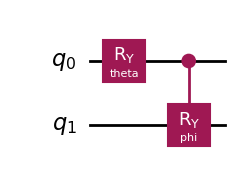

In [83]:
from qiskit.circuit import QuantumCircuit,\
                           Parameter
var_par1 = Parameter('theta')
var_par2 = Parameter('phi')

qc_ = QuantumCircuit(2)

qc_.ry(var_par1,0)
qc_.cry(var_par2,0,1)
qc_.draw(output = 'mpl', style =  'iqx', filename = 'ansatz.pdf')

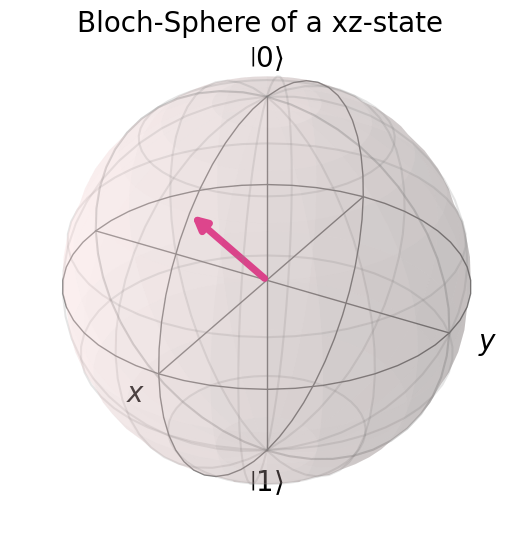

In [84]:
a = np.sqrt(2)
plot_bloch_vector([1/a,0,1/a], title="Bloch-Sphere of a xz-state")

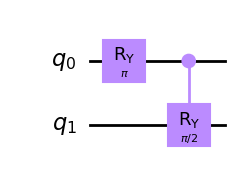

In [86]:
qc_par = qc_.bind_parameters({var_par1: np.pi, var_par2: np.pi/2})
#qc_par.save_statevector()
qc_par.draw('mpl')

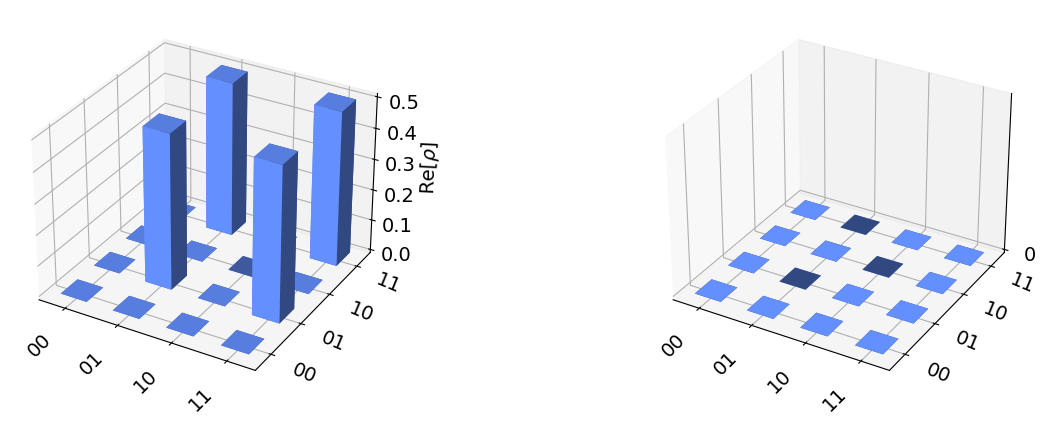

In [81]:
state = Statevector(qc_par)
plot_state_city(state)

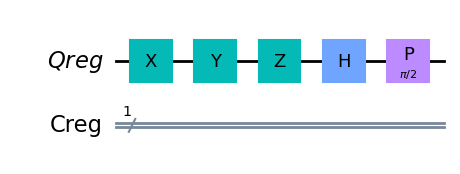

In [24]:
qr = QuantumRegister(1, 'Qreg')
cr = ClassicalRegister(1, 'Creg')

qc = QuantumCircuit()
qc.add_register(qr)
qc.add_register(cr)

qc.x(0)
qc.y(0)
qc.z(0)
qc.h(0)
qc.p(np.pi/2, 0)


qc.draw('mpl')

Initialize a Bell state by applying Haddamard to G0 and CNOT on G1, using G0 as control gate.

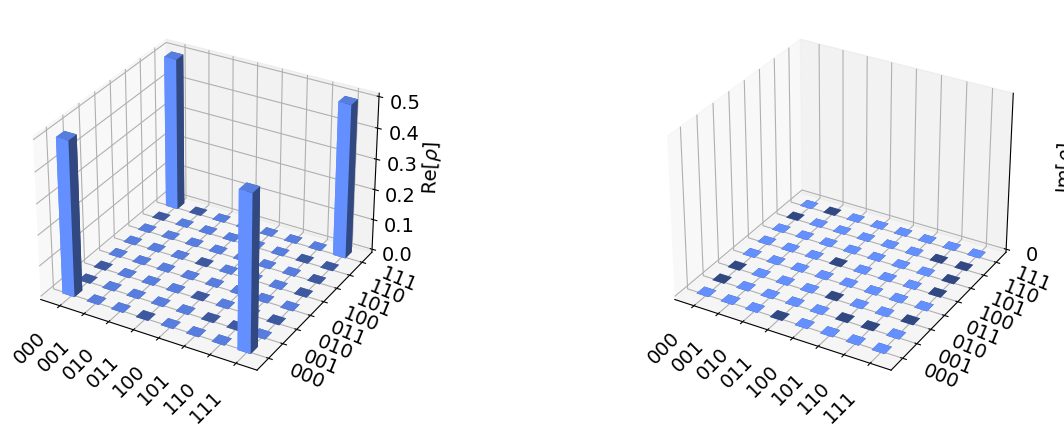

In [194]:
qc_2 = QuantumCircuit()

qr_2 = QuantumRegister(3, 'qreg')
qc_2.add_register(qr_2)

cr_2 = ClassicalRegister(3, 'creg')
qc_2.add_register(cr_2)
qc_2.h(0)
qc_2.cx(0,1)
qc_2.cx(1,2)

state = Statevector(qc_2)
plot_state_city(state)

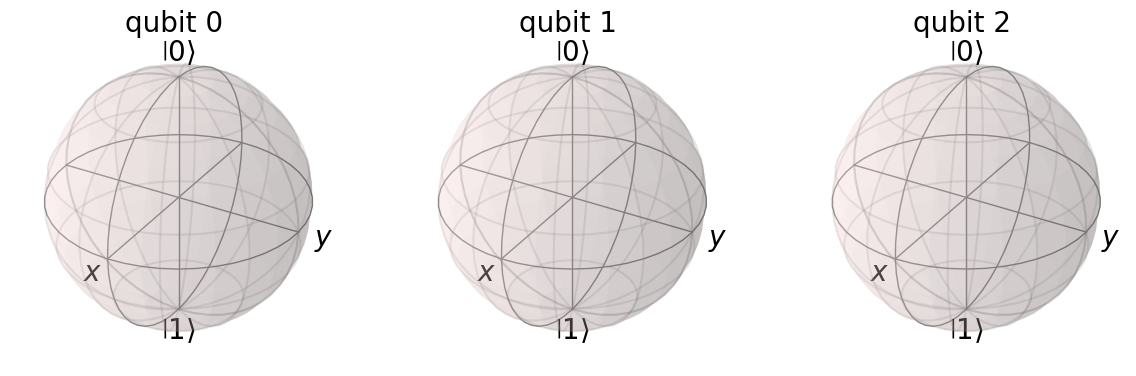

In [190]:
out1 = execute(qc_2,state_sim).result().get_statevector()
plot_bloch_multivector(out1)


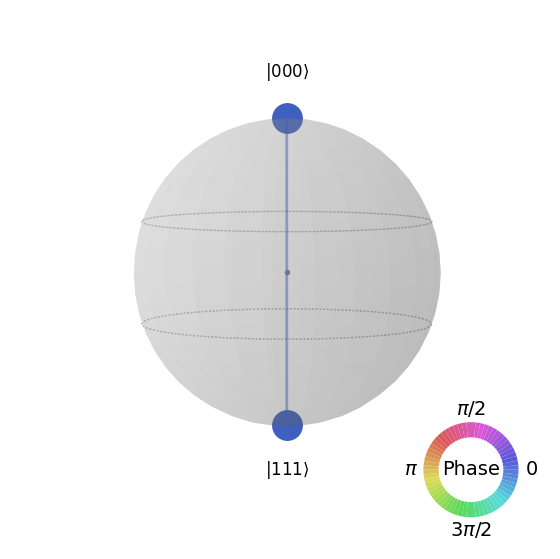

In [191]:
plot_state_qsphere(state)

In [195]:
qc_2.measure(0,0)
qc_2.measure(1,1)
qc_2.measure(2,2)

qc_2.draw()

┌───┐          ┌─┐      
qreg_0: ┤ H ├──■───────┤M├──────
        └───┘┌─┴─┐     └╥┘┌─┐   
qreg_1: ─────┤ X ├──■───╫─┤M├───
             └───┘┌─┴─┐ ║ └╥┘┌─┐
qreg_2: ──────────┤ X ├─╫──╫─┤M├
                  └───┘ ║  ║ └╥┘
creg: 3/════════════════╩══╩══╩═
                        0  1  2

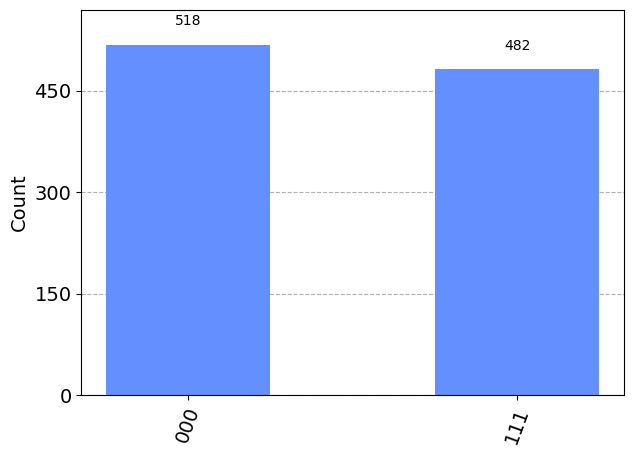

In [196]:
job = simulator.run(qc_2, shots=1000)
hist = job.result().get_counts()
plot_histogram(hist)

This is statistically in accordance with the expected Bell states.

## b


Here we initialize the Hamiltonian matrices and solve it using eigsolvers.


[[2.         0.13333333]
 [0.13333333 2.        ]]

[2.13333333 1.86666667] 

 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


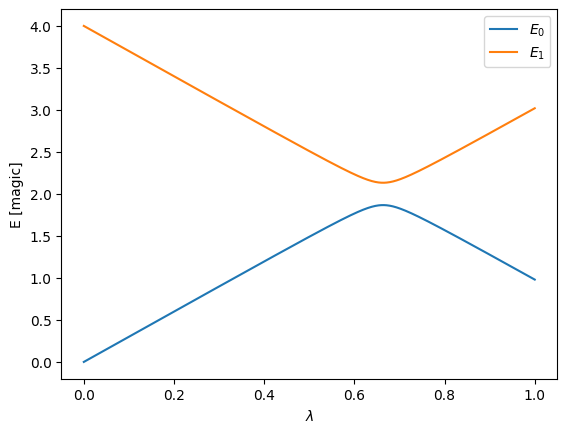

In [28]:
H0 = np.eye(2)
E1 = 0; E2 = 4
H0[0,0] = E1; H0[1,1] = E2


H1 = np.eye(2)
v11 = 3; v22 = -v11; v12 = 0.2; v21 = v12
H1[0,0] = v11; H1[0,1] = v12; H1[1,0] = v21; H1[1,1] = v22 

lmd_ = 2/3#Range [0,1]
pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])
c = (v11 + v22)/2
omega_z = (v11-v22)/2
omega_x = v12

H_ = H0 + lmd_*H1

print(H_)
print()
eig_val, eig_vec = np.linalg.eig(H_)
print(eig_val,'\n\n', eig_vec)


n = 1000
lambdas = np.linspace(0,1,n)
Es = np.zeros((n,2))
C1s, C2s  = np.zeros_like(Es), np.zeros_like(Es)
for i, lmd_ in enumerate(lambdas):
    H_ = H0 + lmd_*H1
    eig_val, eig_vec = np.linalg.eigh(H_)
    # print(H_)
    Es[i,:] = eig_val
    C1s[i,:] = eig_vec[:,0]
    C2s[i,:] = eig_vec[:,1] 

fig, ax = plt.subplots()
ax.plot(lambdas, Es[:,0], label=r"$E_0$")
ax.plot(lambdas, Es[:,1], label=r"$E_1$")
ax.set(xlabel=r"$\lambda$", ylabel="E [magic]")
ax.legend() # Kan legge til fancy-pancy color bar for a vise "change of character" opplegget?

## c


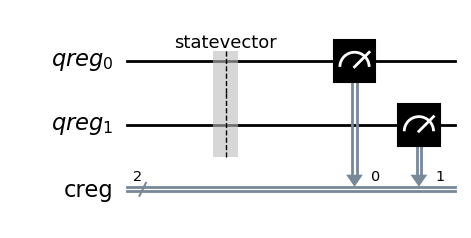

In [29]:
qc_3 = QuantumCircuit()

qr_3 = QuantumRegister(2, 'qreg')
qc_3.add_register(qr_3)

cr_3 = ClassicalRegister(2, 'creg')
qc_3.add_register(cr_3)

eta = (E1 + E2)/2
Omega = (E1-E2)/2
H0 = eta*np.eye(2) + Omega*pauli_z
are = Operator(Pauli('X'))

H1 = c * np.eye(2) + omega_z * pauli_z + omega_x * pauli_x

X_op = Operator(Pauli('X'))
Z_op = Operator(Pauli('Z'))
idty = Operator(np.eye(2))

qc_3.save_statevector()
qc_3.measure(qr_3[0], cr_3[0])
qc_3.measure(qr_3[1], cr_3[1])
qc_3.draw('mpl')

En måte:

In [136]:
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

In [137]:
c = (v11 + v22)/2
omega_z = (v11-v22)/2
omega_x = v12
eta = (E1+E2)/2
omega_ = (E1-E2)/2

HH = eta*np.kron(I,I) + omega_ * np.kron(Z,I) + c * np.kron(I,I) + omega_z * np.kron(I,Z) + omega_x * np.kron(I,X) 
val, vec = np.linalg.eig(HH)
print(val)

h1_val = c + eta
h2_val = omega_
h3_val = omega_z
h4_val = omega_x

h1 = [h1_val, [0,1] , ['I']]
h2 = [h2_val, [0] , ['Z']]
h3 = [h3_val, [1] , ['Z']]
h4 = [h4_val, [1] , ['X']]

H = [h1,h2,h3,h4]
H

[ 3.00665928 -3.00665928  7.00665928  0.99334072]


[[2.0, [0, 1], ['I']],
 [-2.0, [0], ['Z']],
 [3.0, [1], ['Z']],
 [0.2, [1], ['X']]]

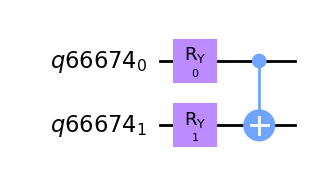

In [140]:
def ansatz(theta,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    param_list =[]
    for j in range(len(theta)):
        par = Parameter('theta %s' %j)
        param_list.append(par)
    for i in range(n_qubits):
        circuit.ry(param_list[i],qreg[i])
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    dictus ={}
    for j in range(len(theta)):
        dictus[param_list[j]] = theta[j]
    circuit = circuit.bind_parameters(dictus)
    return(circuit)

cc = ansatz([0,1], 2)
cc.draw('mpl')

Before ansatz


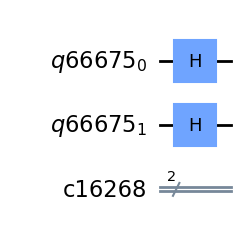

In [141]:
n_qbits = 2
theta = np.random.randn(2)

qc = QuantumCircuit()
qreg = QuantumRegister(2)
creg = ClassicalRegister(2)

qc.add_register(qreg)
qc.add_register(creg)
qc.h(qreg[:])

print('Before ansatz')
qc.draw('mpl')

After ansatz


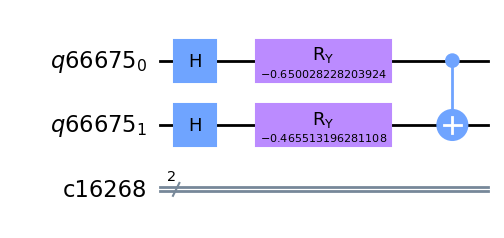

In [142]:
qc = qc.compose(ansatz(theta,n_qbits))
print('After ansatz')
qc.draw('mpl')

In [144]:
def basis_change(h_i,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'X':
            circuit.h(qreg[qubit]) 
    return(circuit)

After basis transformation:


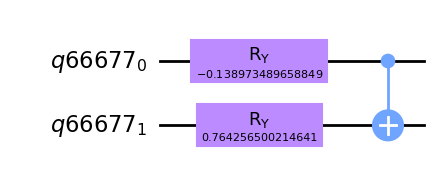

In [145]:
n_qubits = 2
theta = np.random.randn(n_qubits)

qreg = QuantumRegister(n_qubits)
qc = QuantumCircuit(qreg)
qc = qc.compose(ansatz(theta,n_qubits))
qc = qc.compose(basis_change(H[0],n_qubits))
print('After basis transformation:')
qc.draw('mpl')

In [146]:
def get_energy(theta):
    n_qubits = 2
    qreg = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qreg)
    qc = qc.compose(ansatz(theta,n_qubits))
    qc_list = []
    for idx,h_i in enumerate(H):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_qc = qc.compose(basis_change_circuit)
        creg = ClassicalRegister(len(h_i[1]))
        new_qc.add_register(creg)
        new_qc.measure(qreg[h_i[1]],creg)
        qc_list.append(new_qc)
        
    shots = 1000
    job = simulator.run(qc_list,shots=shots)
    E = np.zeros(len(qc_list))
    for i in range(len(E)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H[i][0]
    E /= shots
    return(np.sum(E))

theta = np.random.randn(2)

get_energy(theta)

2.71336

In [147]:
theta = np.random.randn(2)
res = minimize(get_energy, theta, method='Powell',tol=1e-12)
get_energy(res.x)

-7.00516

In [153]:
epochs = 200
theta = np.random.randn(2)
for epoch in range(epochs):
    print(epoch,get_energy(theta))
    grad = np.zeros_like(theta)
    for idx in range(theta.shape[0]):
        theta_temp = theta.copy()
        theta_temp[idx] += np.pi/2
        E_plus = get_energy(theta_temp)
        theta_temp[idx] -= np.pi
        E_minus = get_energy(theta_temp)
        grad[idx] = (E_plus - E_minus)/2
    theta -= 0.1*grad

0 1.5614
1 1.3976
2 1.1760000000000002
3 0.909
4 0.5913999999999999
5 0.223
6 -0.199
7 -0.6015999999999999
8 -0.9368
9 -1.225
10 -1.4708
11 -1.6263999999999998
12 -1.7542
13 -1.8376000000000001
14 -1.8956
15 -1.9331999999999998
16 -1.9567999999999999
17 -1.9742000000000002
18 -1.9817999999999998
19 -1.9876
20 -1.9916
21 -1.9944000000000002
22 -1.996
23 -1.9982000000000002
24 -1.9976
25 -1.9994
26 -1.9996
27 -1.9994
28 -2.0
29 -1.9996
30 -1.9998
31 -2.0
32 -2.0
33 -1.9998
34 -2.0
35 -2.0
36 -2.0
37 -2.0
38 -2.0
39 -2.0
40 -2.0
41 -1.9998
42 -2.0
43 -2.0
44 -2.0
45 -2.0
46 -2.0
47 -2.0
48 -2.0
49 -2.0
50 -2.0
51 -2.0
52 -2.0
53 -2.0
54 -2.0
55 -2.0
56 -2.0
57 -2.0
58 -2.0
59 -2.0
60 -2.0
61 -2.0
62 -2.0
63 -2.0
64 -2.0
65 -2.0
66 -2.0
67 -2.0
68 -2.0
69 -2.0
70 -2.0
71 -2.0
72 -2.0
73 -2.0
74 -2.0
75 -2.0
76 -2.0
77 -2.0
78 -2.0
79 -2.0
80 -2.0
81 -2.0
82 -2.0
83 -2.0
84 -2.0
85 -2.0
86 -2.0
87 -2.0
88 -2.0
89 -2.0
90 -2.0
91 -2.0
92 -2.0
93 -2.0
94 -1.9998
95 -2.0
96 -2.0
97 -2.0
98 -2.

In [114]:
#1d
#Skal gjennomføres som funksjon av lambda, tar det siden
lmd_ = 0.8
s_00 = np.array([1,0,0,0])
s_10 = np.array([0,1,0,0])
s_01 = np.array([0,0,1,0])
s_11 = np.array([0,0,0,1])
        
eps_list = [0,2.5,6.5,7]
H0 = np.eye(4)
H0[0,0] = eps_list[0];H0[1,1] = eps_list[1];H0[2,2] = eps_list[2];H0[3,3] = eps_list[3]

pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])
H_x = 2.0
H_z = 3.0
H_I = H_x * np.kron(pauli_x, pauli_x) + H_z * np.kron(pauli_z, pauli_z)

H_tot = H0 + lmd_*H_I
eig_vals, eig_vecs = np.linalg.eig(H_tot)

#Computing partial density matrix
rho_a = (eig_vecs[0].max() + eig_vecs[1].max()) * np.outer(s_00,s_00) + (eig_vecs[2].max() + eig_vecs[3].max()) * np.outer(s_11,s_11)
rho_b = (eig_vecs[0].max() + eig_vecs[2].max()) * np.outer(s_00,s_00) + (eig_vecs[1].max() + eig_vecs[3].max()) * np.outer(s_11,s_11)

#Compute entropy
S_a = - np.trace(rho_a)*np.log2(np.trace(rho_a))
S_b = - np.trace(rho_b)*np.log2(np.trace(rho_b))
S_a, S_b


(-3.207020335903938, -3.207020335903938)

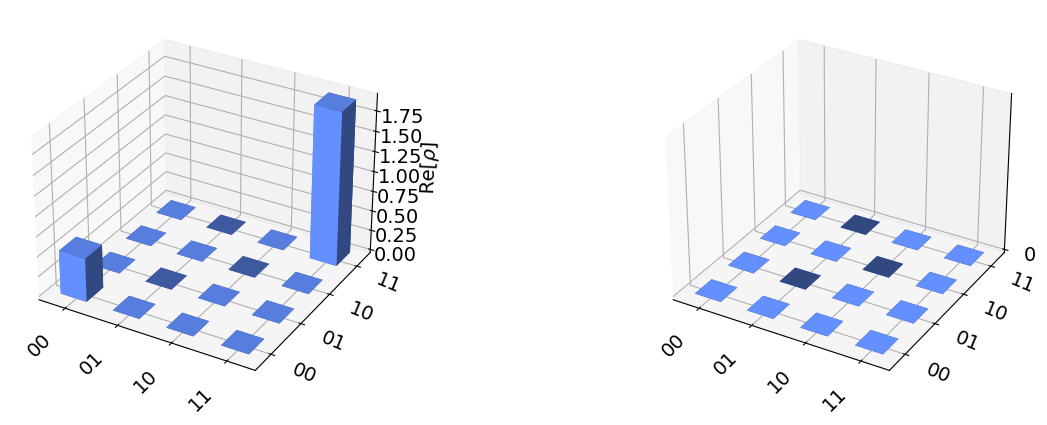

In [113]:
var_a = DensityMatrix(rho_a)
plot_state_city(var_a)

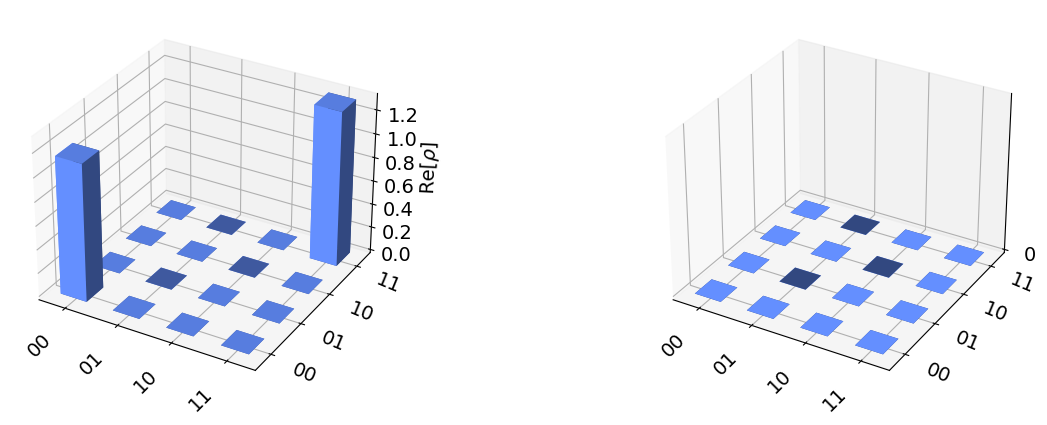

In [112]:
var_b = DensityMatrix(rho_b)
plot_state_city(var_b)

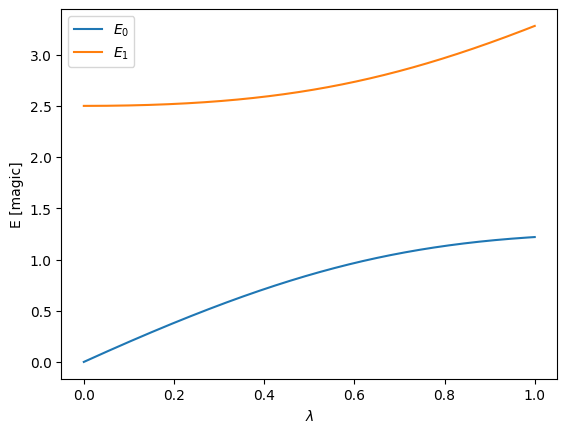

In [20]:
n = 1000
lambdas = np.linspace(0,1,n)
Es = np.zeros((n,4))
C1s, C2s  = np.zeros_like(Es), np.zeros_like(Es)

for i, lmd_ in enumerate(lambdas):
    H_ = H0 + lmd_*H1
    eig_val, eig_vec = np.linalg.eigh(H_)
    Es[i,:] = eig_val

fig, ax = plt.subplots()
ax.plot(lambdas, Es[:,0], label=r"$E_0$")
ax.plot(lambdas, Es[:,1], label=r"$E_1$")
ax.set(xlabel=r"$\lambda$", ylabel="E [magic]")
ax.legend() 

The entropy is as expected, similar, as there are no difference in the configuration of the two states. As such, there should be an equal amount of entanglement entropy. The energies follow the same asymptotic convergence, which indeed confirms their entanglement.

## Stian-måten


In [149]:
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
hx = 2; hz = 3; eps_list = [0,2.5,6.5,7]

H_0 = np.matrix([[eps_list[0],0,0,0],[0,eps_list[1],0,0],[0,0,eps_list[2],0],[0,0,0,eps_list[3]]])
H_I = hx * np.kron(X,X) + hz* np.kron(Z,Z) 
H = H_0 + H_I
eigvals,eigvecs = np.linalg.eigh(H)
print(eigvals)
print(eigvecs)

c_1 = 1
c_2 = 1
c_3 = 1

h_1 = [c_1,[0],['z,z']]
h_2 = [c_2,[1],['x,x']]
H = [h_1,h_2]

[-1.32842712  2.46887113  4.32842712 10.53112887]
[[-0.         -0.96649965  0.         -0.25666794]
 [ 0.92387953  0.         -0.38268343  0.        ]
 [-0.38268343  0.         -0.92387953  0.        ]
 [ 0.          0.25666794  0.         -0.96649965]]


In [150]:
qreg = QuantumRegister(n_qubits)
circuit = QuantumCircuit(qreg)
circuit.h(qreg[:2])
print('Before ansatz')
print(circuit.draw())
theta = np.random.randn(2)
n_qubits = 2
circuit = circuit.compose(ansatz(theta,n_qubits))
print('After ansatz')
print(circuit.draw())

Before ansatz
          ┌───┐
q69011_0: ┤ H ├
          ├───┤
q69011_1: ┤ H ├
          └───┘
After ansatz
          ┌───┐┌───────────────────────┐     
q69011_0: ┤ H ├┤ Ry(0.930799911274534) ├──■──
          ├───┤├───────────────────────┤┌─┴─┐
q69011_1: ┤ H ├┤ Ry(-1.12147518140255) ├┤ X ├
          └───┘└───────────────────────┘└───┘


In [151]:
def basis_change(h_i,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    
    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'x':
            circuit.h(qreg[qubit])
    return(circuit)
n_qubits = 2
qreg = QuantumRegister(n_qubits)
circuit = QuantumCircuit(qreg)
theta = np.random.randn(n_qubits)
circuit = circuit.compose(ansatz(theta,n_qubits))
print('Ansatz circuit')
print(circuit.draw())
circuit = circuit.compose(basis_change(H[1],n_qubits))
print('After basis transformation:')
print(circuit.draw())

Ansatz circuit
          ┌───────────────────────┐     
q69013_0: ┤ Ry(-1.18117520838852) ├──■──
          ├───────────────────────┤┌─┴─┐
q69013_1: ┤ Ry(0.542278663206287) ├┤ X ├
          └───────────────────────┘└───┘
After basis transformation:
          ┌───────────────────────┐     
q69013_0: ┤ Ry(-1.18117520838852) ├──■──
          ├───────────────────────┤┌─┴─┐
q69013_1: ┤ Ry(0.542278663206287) ├┤ X ├
          └───────────────────────┘└───┘


In [152]:
def get_energy(theta):
    n_qubits = 2
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    circuit = circuit.compose(ansatz(theta,n_qubits))
    circuit_list = []
    for idx,h_i in enumerate(H):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_circuit = circuit.compose(basis_change_circuit)
        creg = ClassicalRegister(len(h_i[1]))
        new_circuit.add_register(creg)
        new_circuit.measure(qreg[h_i[1]],creg)
        circuit_list.append(new_circuit)
    shots = 10000
    job = simulator.run(circuit_list,shots=shots)
    E = np.zeros(len(circuit_list))
    for i in range(len(circuit_list)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H[i][0]
    E /= shots
    return(np.sum(E))

theta = np.random.randn(2)
get_energy(theta)

0.08

In [122]:
#Minimize the data
theta = np.random.randn(2)
res = minimize(get_energy, theta, method='Powell',tol=1e-12)
get_energy(res.x)

-2.0

In [99]:
##Gradient descent
epochs = 200
theta = np.random.randn(2)
for epoch in range(epochs):
    print(epoch,get_energy(theta))
    grad = np.zeros_like(theta)
    for idx in range(theta.shape[0]):
        theta_temp = theta.copy()
        theta_temp[idx] += np.pi/2
        E_plus = get_energy(theta_temp)
        theta_temp[idx] -= np.pi
        E_minus = get_energy(theta_temp)
        grad[idx] = (E_plus - E_minus)/2
    theta -= 0.1*grad

0 2.8587599999999997
1 2.5185999999999997
2 1.74168
3 0.23412000000000022
4 -2.06448
5 -4.63068
6 -6.2926400000000005
7 -6.95284
8 -7.1316
9 -7.18796
10 -7.19696
11 -7.19956
12 -7.2
13 -7.2
14 -7.19956
15 -7.1994
16 -7.1994
17 -7.2
18 -7.2
19 -7.2
20 -7.2
21 -7.2
22 -7.2
23 -7.2
24 -7.2
25 -7.2
26 -7.2
27 -7.1994
28 -7.2
29 -7.2
30 -7.2
31 -7.2
32 -7.2
33 -7.2
34 -7.2
35 -7.2
36 -7.2
37 -7.19996
38 -7.2
39 -7.2
40 -7.2
41 -7.2
42 -7.2
43 -7.2
44 -7.2
45 -7.2
46 -7.2
47 -7.2
48 -7.19996
49 -7.2
50 -7.2
51 -7.19996
52 -7.2
53 -7.2
54 -7.2
55 -7.2
56 -7.2
57 -7.2
58 -7.2
59 -7.2
60 -7.2
61 -7.2
62 -7.2
63 -7.1994
64 -7.2
65 -7.2
66 -7.2
67 -7.2
68 -7.2
69 -7.2
70 -7.2
71 -7.2
72 -7.2
73 -7.2
74 -7.2
75 -7.2
76 -7.2
77 -7.2
78 -7.2
79 -7.2
80 -7.2
81 -7.2
82 -7.2
83 -7.2
84 -7.2
85 -7.2
86 -7.2
87 -7.2
88 -7.2
89 -7.2
90 -7.1994
91 -7.2
92 -7.2
93 -7.2
94 -7.1994
95 -7.2
96 -7.19996
97 -7.2
98 -7.2
99 -7.2
100 -7.2
101 -7.2
102 -7.2
103 -7.2
104 -7.2
105 -7.2
106 -7.2
107 -7.2
108 -7.2
109

## 1f)

In [101]:
v =1
I = np.eye(2)
H_4 = -(np.kron(pauli_z,I) + np.kron(I, pauli_z)) - np.sqrt(6)/2 * v *(np.kron(pauli_x, I) + 
                                                                       np.kron(I, pauli_x) + 
                                                                       np.kron(pauli_x, pauli_z) - 
                                                                       np.kron(pauli_z, pauli_x))
H_4_o = - pauli_z - 3*v*pauli_x


eigval_even, eigvec_even = np.linalg.eig(H_4)
eigval_odd, eigvec_odd = np.linalg.eig(H_4_o)

print(eigval_even)
print(eigval_odd)

H_op = Operator(H_4)


[-4.00000000e+00 -2.12178365e-16  4.00000000e+00 -0.00000000e+00]
[-3.16227766  3.16227766]


Disse verdiene stemmer på en såkalt prikk med analytiske verdier. Det er jo ganske lovende. Det er mulig her å lage noen fancy plot der vi varierer på v, eller tilnærmer Hartree-Fock?

Det er ganske snodig dette med VQE, men prøver bare:

In [39]:
h1_lip = [-1, [0,1], ['z']]
h2_lip = [-np.sqrt(6)/2*v, [0], ['x']]
h3_lip = [-np.sqrt(6)/2*v, [1], ['x']]
h4_lip = [-np.sqrt(6)/2*v, [0,1], ['xz']]
h5_lip = [np.sqrt(6)/2*v, [0,1], ['zx']]
H_4_lip = [h1_lip, h2_lip, h3_lip, h4_lip, h5_lip]

In [92]:
def ansatz(theta,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    param_list =[]
    for j in range(len(theta)):
        par = Parameter('theta %s' %j)
        param_list.append(par)
    
    for i in range(n_qubits):
        circuit.ry(param_list[i-1],qreg[i])
    for i in range(n_qubits-1):
        circuit.cry(param_list[i],qreg[i],qreg[i+1])
    dictus ={}
    for j in range(len(theta)):
        dictus[param_list[j]] = theta[j]
    circuit = circuit.bind_parameters(dictus)
    circuit = transpile(circuit, backend = simulator)
    return(circuit)

def basis_change(h_i , n_qubits):
    qreg = QuantumRegister(n_qubits)
    bas_circ = QuantumCircuit(qreg)
    bas_circ = bas_circ.compose(ansatz(theta,n_qubits))

    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'x':
            if qubit == 1:
                bas_circ.h(qreg[qubit])
            if qubit == 0:
                bas_circ.h(qreg[qubit])
        if operator == 'xz':
            bas_circ.h(qreg[qubit])
        if operator == 'zx':
            bas_circ.h(qreg[qubit+1])
    return(bas_circ)

def get_energy(theta, n_qubits=2):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    circuit_list = []
    for idx,h_i in enumerate(H_4_lip):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_circuit = circuit.compose(basis_change_circuit)
        creg = ClassicalRegister(len(h_i[1]))
        new_circuit.add_register(creg)
        new_circuit.measure(qreg[h_i[1]],creg)
        circuit_list.append(new_circuit)
    shots = 1000
    job = simulator.run(circuit_list,shots=shots)
    E = np.zeros(len(circuit_list))
    for i in range(len(circuit_list)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H_4_lip[i][0]
    E /= shots
    return(np.sum(E))


"""
minval = 0 
for i in range(10000):
    theta= np.random.randn(2)
    a = get_energy(theta)
    if a<minval:
        print(a, theta)
        minval=a
#print(a)
"""

'\nminval = 0 \nfor i in range(10000):\n    theta= np.random.randn(2)\n    a = get_energy(theta)\n    if a<minval:\n        print(a, theta)\n        minval=a\n#print(a)\n'

Har her en beste på -33.91

In [132]:
n_qubits = 2
theta = np.random.randn(2)
res = minimize(get_energy, theta, method='Powell',tol=1e-12)
get_energy(res.x)

-19.475647032134034

Egenverdier skal være $\big[0, \pm 30.01,\pm 34.69 \big]$ for v = 10, der 30 er for 2x2 matrisen.

Det er forskjell i hvilke forventningsverdier jeg får her og i det analytiske. Tror vi at det er fordi rotasjonsgatene påvirker det endelige resultatet, eller er det fordi jeg har implementert gates feil? Tar veldig gjerne input.

In [93]:
##Gradient descent
epochs = 200
theta = np.random.randn(2)
for epoch in range(epochs):
    print(epoch,get_energy(theta,2))
    grad = np.zeros_like(theta)
    
    for idx in range(theta.shape[0]):
        theta_temp = theta.copy()
        theta_temp[idx] += np.pi/20
        E_plus = get_energy(theta_temp)
        theta_temp[idx] -= np.pi/10
        E_minus = get_energy(theta_temp)
        grad[idx] = (E_plus - E_minus)/2
    theta -= 0.5*grad

0 1.197938769133982
1 -0.5287040508142429
2 1.5758775382679624
3 3.6079438196336637
4 6.436857023834318
5 10.961402842838861
6 16.45273435381234
7 16.57770373837933
8 2.5126836405255704
9 11.296846714545012
10 15.946341507827873
11 22.386417890192938
12 18.180326148038887
13 8.09300494635471
14 12.674540560214918
15 14.046234405884826
16 7.197703946669272
17 18.853193481162506
18 20.68725976252821
19 17.409004738064766
20 16.33423945638451
21 12.188642611658283
22 5.072647870447907
23 -4.073948870133346
24 -5.794591690081571
25 3.5394693324945052
26 3.0290764865100375
27 10.714948765988375
28 7.755086587509403
29 -6.285499843782543
30 1.4409081537009718
31 2.9375917942265426
32 4.1743366656181315
33 6.169413152128169
34 -0.49618874309773875
35 -0.9390968967987108
36 -11.353469124204564
37 -11.397530355070582
38 -9.990310996539833
39 -12.887203790451817
40 -11.987469124204564
41 -17.73671899402335
42 -18.70801999370879
43 -20.084310788249894
44 -10.86979568882333
45 -11.414683432235629


KeyboardInterrupt: 

In [103]:
def lip_ham(v):
    reg = -(np.kron(pauli_z,I) + np.kron(I, pauli_z))
    ireg = - np.sqrt(6)/2 * v *(np.kron(pauli_x, I) + np.kron(I, pauli_x) + np.kron(pauli_x, pauli_z) - np.kron(pauli_z, pauli_x))
    return reg + ireg

epochs = 1000
v = np.linspace(0,2,20)
min_eigval_list = []
eps = 3
theta = np.random.randn(2)

for i in range(len(v)):
    a = lip_ham(v[i])
    for j in range(epochs):
        #Gradient descent, som funksjon av v
        alt = 0
    min_eigval_list.append(alt)
